In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.graphics.tsaplots as F
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from arima_model import arima_model
from scipy.stats import boxcox


Reading data and geting basic info of the data


In [3]:
df_d=pd.read_csv("/home/jack/data_mining/PROJECT/data/day.csv")
d_s=df_d.sample(n=3,replace=False,random_state=42)#n=3 (show 3 rows random) repalce=Fals the sample rows are unique random_state
#so I can generate same result again and again
print(d_s)


     instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
703      704  2012-12-04       4   1    12        0        2           1   
33        34  2011-02-03       1   0     2        0        4           1   
300      301  2011-10-28       4   0    10        0        5           1   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
703           1  0.475833  0.469054  0.733750   0.174129     551        6055   
33            1  0.186957  0.177878  0.437826   0.277752      61        1489   
300           2  0.330833  0.318812  0.585833   0.229479     456        3291   

      cnt  
703  6606  
33   1550  
300  3747  


In [4]:
df_h=pd.read_csv("/home/jack/data_mining/PROJECT/data/hour.csv")
d_hs=df_h.sample(n=3,replace=False,random_state=42)
print(d_hs)

       instant      dteday  season  yr  mnth  hr  holiday  weekday  \
12830    12831  2012-06-23       3   1     6  19        0        6   
8688      8689  2012-01-02       1   1     1  20        1        1   
7091      7092  2011-10-28       4   0    10   2        0        5   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
12830           0           1  0.80  0.6970  0.27     0.1940     185   
8688            0           1  0.24  0.2273  0.41     0.2239       5   
7091            1           1  0.32  0.3030  0.66     0.2836       1   

       registered  cnt  
12830         240  425  
8688           83   88  
7091            3    4  


#converting date and time to datetime

In [5]:
df_d['dteday']=pd.to_datetime(df_d['dteday'])
df_h['dteday']=pd.to_datetime(df_h['dteday'])

#setting index to columns

In [6]:
df_d.set_index("dteday",inplace=True)
df_h.set_index("dteday",inplace=True)

In [7]:
print(df_d.head())


            instant  season  yr  mnth  holiday  weekday  workingday  \
dteday                                                                
2011-01-01        1       1   0     1        0        6           0   
2011-01-02        2       1   0     1        0        0           0   
2011-01-03        3       1   0     1        0        1           1   
2011-01-04        4       1   0     1        0        2           1   
2011-01-05        5       1   0     1        0        3           1   

            weathersit      temp     atemp       hum  windspeed  casual  \
dteday                                                                    
2011-01-01           2  0.344167  0.363625  0.805833   0.160446     331   
2011-01-02           2  0.363478  0.353739  0.696087   0.248539     131   
2011-01-03           1  0.196364  0.189405  0.437273   0.248309     120   
2011-01-04           1  0.200000  0.212122  0.590435   0.160296     108   
2011-01-05           1  0.226957  0.229270  0.436957

In [8]:
print(df_h.head())

            instant  season  yr  mnth  hr  holiday  weekday  workingday  \
dteday                                                                    
2011-01-01        1       1   0     1   0        0        6           0   
2011-01-01        2       1   0     1   1        0        6           0   
2011-01-01        3       1   0     1   2        0        6           0   
2011-01-01        4       1   0     1   3        0        6           0   
2011-01-01        5       1   0     1   4        0        6           0   

            weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
dteday                                                                          
2011-01-01           1  0.24  0.2879  0.81        0.0       3          13   16  
2011-01-01           1  0.22  0.2727  0.80        0.0       8          32   40  
2011-01-01           1  0.22  0.2727  0.80        0.0       5          27   32  
2011-01-01           1  0.24  0.2879  0.75        0.0       3        

check null values and info about two data-sets

In [9]:
df_d.info()
print(f"number of rows: {len(df_d)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 91.4 KB
number of rows: 731


In [10]:
df_d.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [11]:
df_h.info()
print(f"number of rows: {len(df_h)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.3 MB
number of rows: 17379


In [12]:
df_h.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


encoding catogorical features

In [13]:
def encoder(df_h,df_d):
    encoded_h = pd.get_dummies(df_h, columns=['yr','hr','season','mnth','weekday','weathersit'
    ])
    encoded_d = pd.get_dummies(df_d, columns=['yr','season','mnth','weekday','weathersit'
    ])
    return encoded_d,encoded_h

In [14]:
encoded_d,encoded_h=encoder(df_d=df_d,df_h=df_h)

chekc how data sets look like

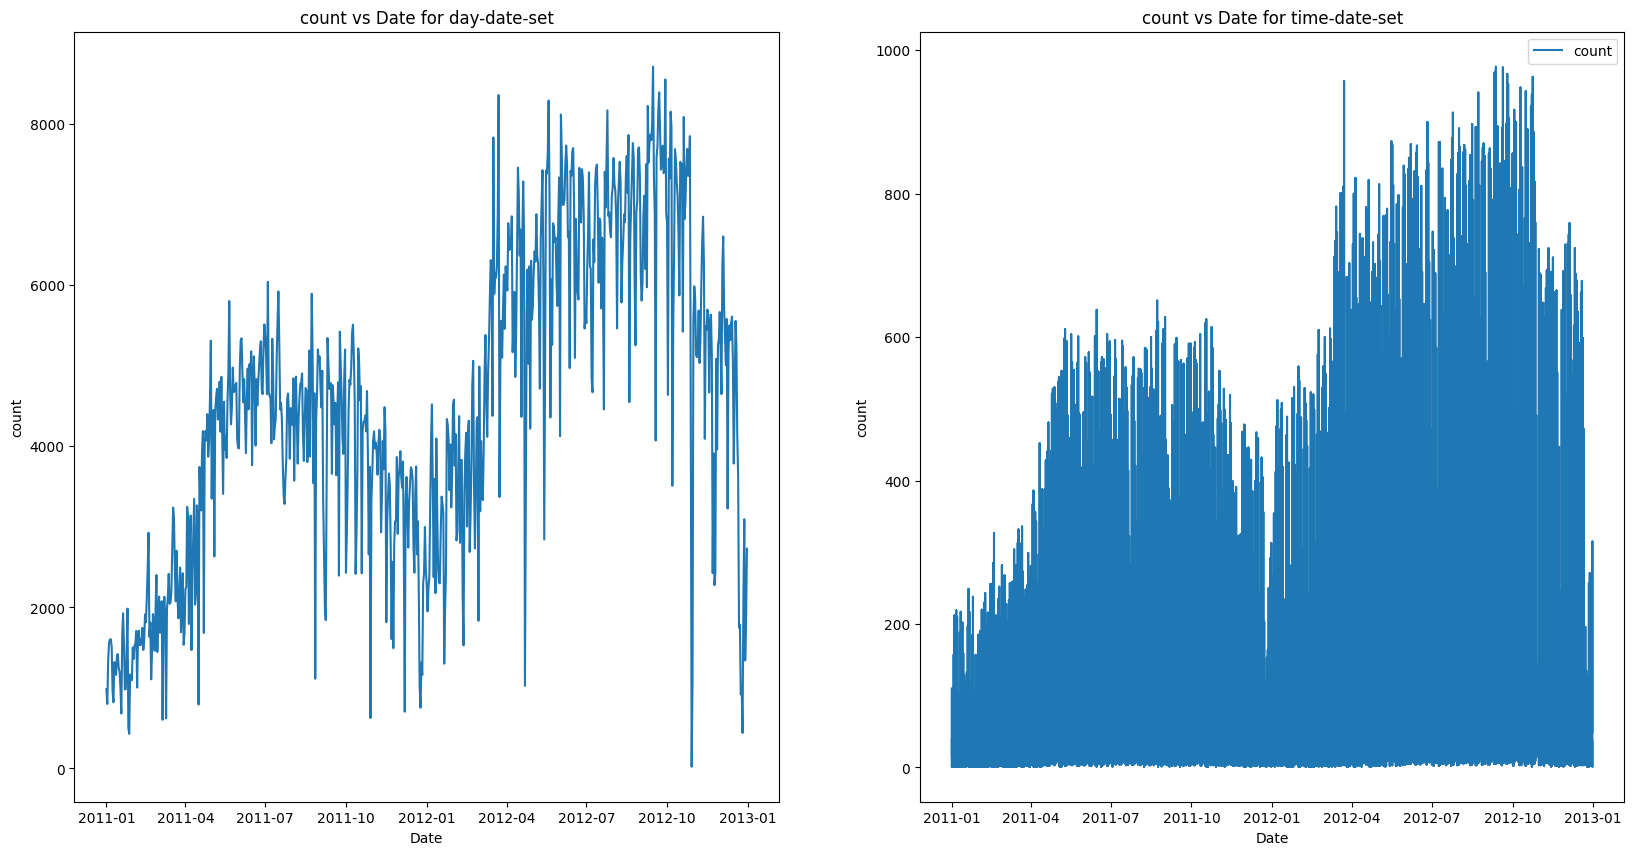

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.plot(encoded_d.index,encoded_d['cnt'],label="count")
ax2.plot(encoded_h.index,encoded_h['cnt'],label='count')
ax1.set_ylabel("count")
ax1.set_xlabel("Date")
ax1.set_title("count vs Date for day-date-set")

ax2.set_ylabel("count")
ax2.set_xlabel("Date")
ax2.set_title("count vs Date for time-date-set")
plt.legend()
plt.show()

checking for seasonality in data-set

In [16]:
encoded_d.head(n=5)

,instant,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,False,False,False,False,False,False,True,False,True,False
2011-01-02,2,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,True,False,False,False,False,False,False,False,True,False
2011-01-03,3,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,False,True,False,False,False,False,False,True,False,False
2011-01-04,4,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,False,False,True,False,False,False,False,True,False,False
2011-01-05,5,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,False,False,False,True,False,False,False,True,False,False


In [17]:
encoded_h.head(n=5)

,instant,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,0,0.24,0.2879,0.81,0.0,3,13,16,...,False,False,False,False,False,True,True,False,False,False
2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,8,32,40,...,False,False,False,False,False,True,True,False,False,False
2011-01-01,3,0,0,0.22,0.2727,0.80,0.0,5,27,32,...,False,False,False,False,False,True,True,False,False,False
2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,3,10,13,...,False,False,False,False,False,True,True,False,False,False
2011-01-01,5,0,0,0.24,0.2879,0.75,0.0,0,1,1,...,False,False,False,False,False,True,True,False,False,False


adf check with making mean and variance constant (making timeseries stationary)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

setting period=7 assumes a 7-day seasonal cycle, detecting weekly patterns (e.g., higher rentals on weekdays vs. weekends).

<Figure size 640x480 with 0 Axes>

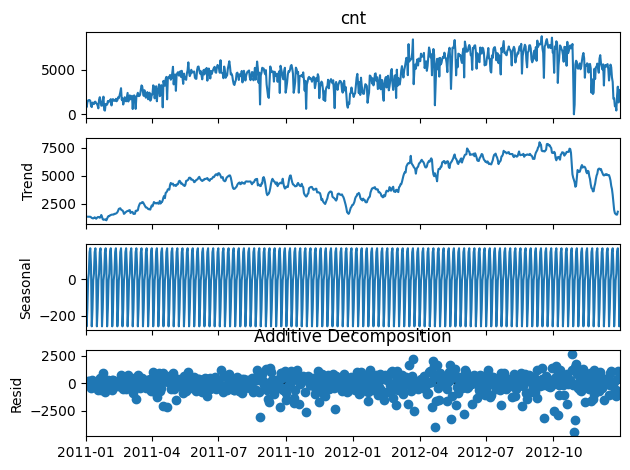

In [19]:
plt.clf()  # Clear any existing figures

additive_result = seasonal_decompose(encoded_d['cnt'], model='additive', period=7)
additive_result.plot()
plt.title('Additive Decomposition')
plt.show()


<Figure size 640x480 with 0 Axes>

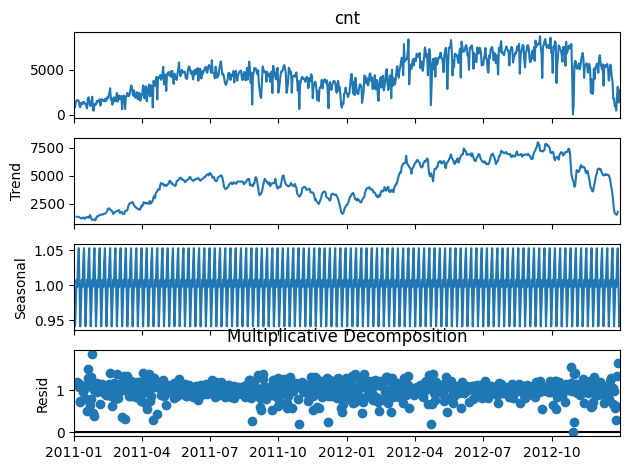

In [20]:
plt.clf()  # Clear any existing figures

multiplicative_result = seasonal_decompose(encoded_d['cnt'], model='multiplicative', period=7)
multiplicative_result.plot()
plt.title('Multiplicative Decomposition')
plt.show()

we do dif(7) because we have seasonality in weekly cycle

we had to do boxcox before using diff because boxcox don't work for negative values

use boxcox

In [21]:
print(encoded_d['cnt'].count())
print(len(encoded_d['cnt']))

731
731


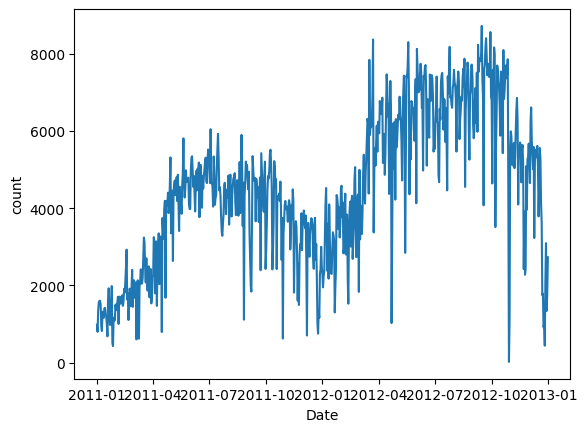

In [22]:
plt.plot(encoded_d.index,encoded_d['cnt'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.show()

In [23]:
encoded_d['cnt_b'],la=boxcox(encoded_d['cnt'])

In [24]:
print(f"lambda value {la:.3f}")

lambda value 0.884


lambda is close to 1 but not 1 it's 0.884 boxcox applied modarate transformation see y axis value! count

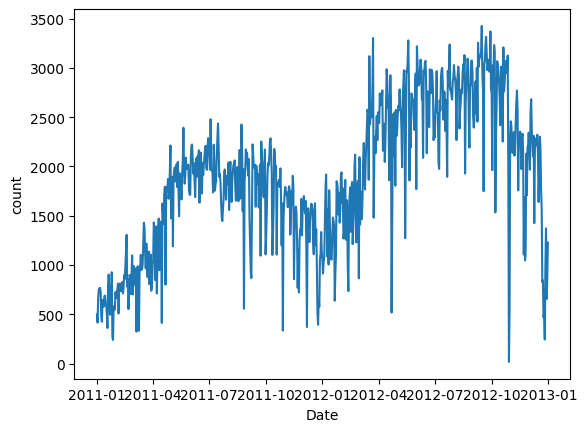

In [25]:
plt.plot(encoded_d.index,encoded_d['cnt_b'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.show()

use log

In [26]:
encoded_d['cnt_l']=np.log(encoded_d['cnt'])

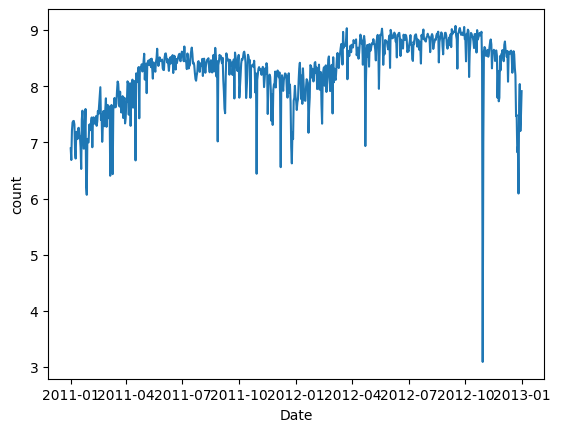

In [27]:
plt.plot(encoded_d.index,encoded_d['cnt_l'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.show()

In [28]:
encoded_d['cnt_by_7b']=encoded_d['cnt_b'].diff(7)

In [29]:
encoded_d['cnt_by_7l']=encoded_d['cnt_l'].diff(7)

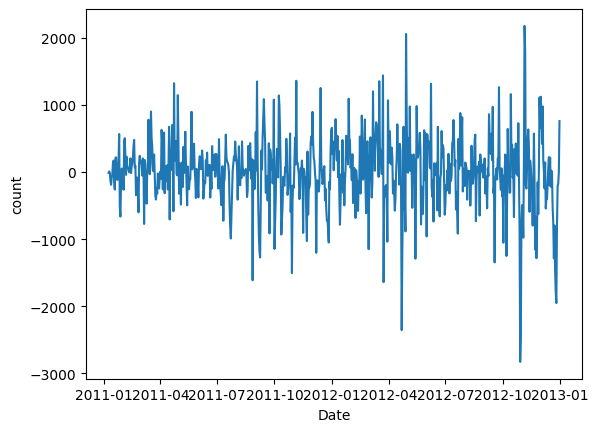

In [30]:
plt.plot(encoded_d.index,encoded_d['cnt_by_7b'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.show()

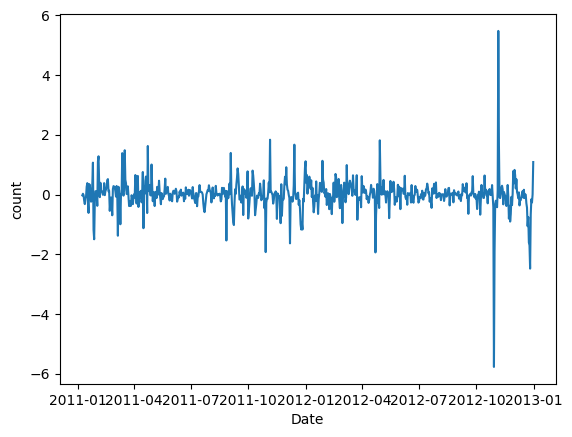

In [31]:
plt.plot(encoded_d.index,encoded_d['cnt_by_7l'],label="after removing weeky seasonality")
plt.xlabel("Date")
plt.ylabel("count")
plt.show()

we can see now mean is constant so do variance boxcox only id modarate variance transform because lambda is close to 1 o.884

<Figure size 640x480 with 0 Axes>

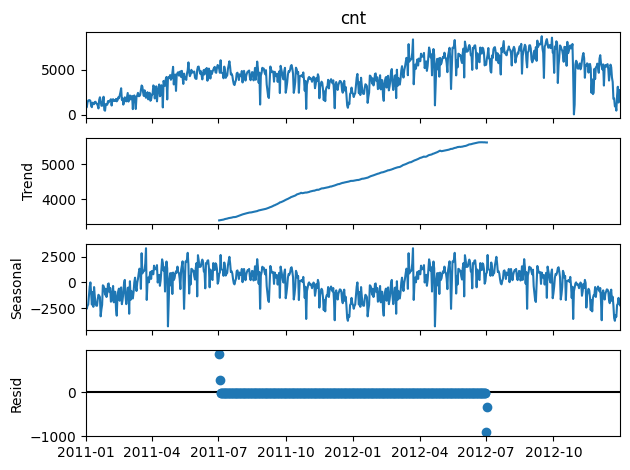

In [32]:
plt.clf()  # Clear any existing figures

decompse = seasonal_decompose(encoded_d['cnt'], model='additive', period=365)
decompse.plot()
plt.show()


In [33]:
def adf_test(series, feature_name='cnt'):
    
    clean_data=series[feature_name].replace([np.inf,-np.inf],np.nan).dropna()
    I=0
    result = adfuller(clean_data)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")
        # series[f"{feature_name}_dif_log"]=np.log(series[feature_name].diff())
        # series[f"{feature_name}_dif_log"]=series[f"{feature_name}_dif_log"].replace([np.inf,-np.inf],np.nan).dropna()
        I+=1
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
        if result[0] < value:
            print(f"At {key} level, series is stationary")
    return I


In [34]:
I_d=adf_test(encoded_d,'cnt_by_7b')

ADF Statistic: -8.014453956100043
p-value: 2.1575573766323978e-12
Series is stationary
Critical Value (1%): -3.4396861854831964
At 1% level, series is stationary
Critical Value (5%): -2.865660062273053
At 5% level, series is stationary
Critical Value (10%): -2.5689640195342456
At 10% level, series is stationary


In [35]:
encoded_d.dropna(subset=['cnt_by_7b'], inplace=True)

<Figure size 640x480 with 0 Axes>

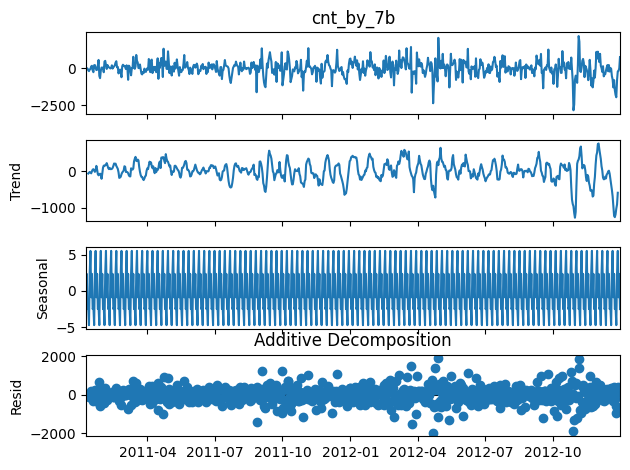

In [36]:
plt.clf()  # Clear any existing figures

additive_result = seasonal_decompose(encoded_d['cnt_by_7b'], model='additive', period=7)
additive_result.plot()
plt.title('Additive Decomposition')
plt.show()

In [37]:
I_d_n=adf_test(encoded_d,'cnt_by_7l')

ADF Statistic: -8.997446952053368
p-value: 6.635543292790239e-15
Series is stationary
Critical Value (1%): -3.4396861854831964
At 1% level, series is stationary
Critical Value (5%): -2.865660062273053
At 5% level, series is stationary
Critical Value (10%): -2.5689640195342456
At 10% level, series is stationary


In [38]:
encoded_d.dropna(subset=['cnt_by_7l'], inplace=True)


<Figure size 640x480 with 0 Axes>

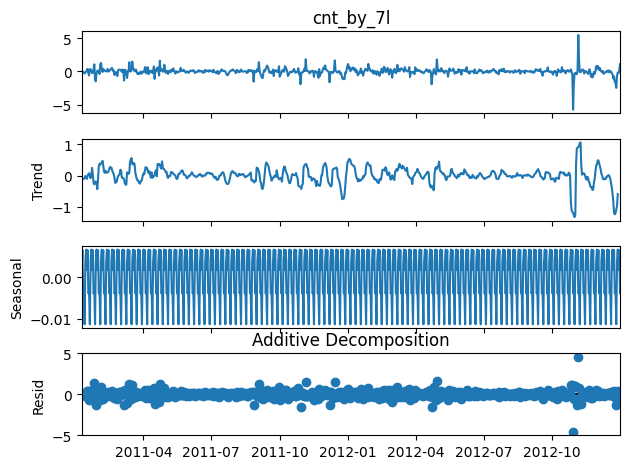

In [39]:
plt.clf()  # Clear any existing figures

additive_result = seasonal_decompose(encoded_d['cnt_by_7l'], model='additive', period=7)
additive_result.plot()
plt.title('Additive Decomposition')
plt.show()

In [40]:
I_h=adf_test(encoded_h,'cnt')

ADF Statistic: -6.82291871189509
p-value: 1.9808626277978587e-09
Series is stationary
Critical Value (1%): -3.430727265144117
At 1% level, series is stationary
Critical Value (5%): -2.8617067365231246
At 5% level, series is stationary
Critical Value (10%): -2.5668587495404225
At 10% level, series is stationary


<Figure size 1000x400 with 0 Axes>

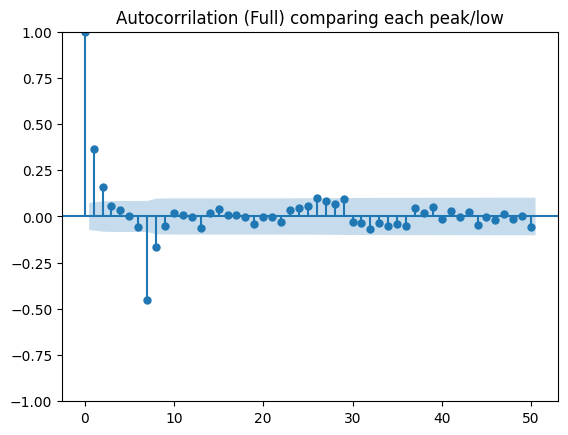

In [41]:
plt.figure(figsize=(10,4))
F.plot_acf(encoded_d["cnt_by_7b"],lags=50)
plt.title("Autocorrilation (Full) comparing each peak/low")#how was today sale compare to yesterday ,daybefore ,...n day before
plt.show()


In [43]:
def check_acf_and_pacf(name_of_data,data, feature='cnt', lag=50):
    series = data[feature].dropna()
    
    # --- Compute ACF and PACF values ---
    acf_vals, confint_acf = acf(series, nlags=lag, alpha=0.05)
    pacf_vals, confint_pacf = pacf(series, nlags=lag, alpha=0.05, method='ywm')

    # --- Determine where they become insignificant (first lag where values stay within CI) ---
    def find_cutoff(values, confint):
        for i in range(1, len(values)):
            lower, upper = confint[i]
            if lower <= values[i] <= upper:
                # Found the first lag that falls within CI (insignificant)
                return i
        return None

    acf_cutoff = find_cutoff(acf_vals, confint_acf)
    pacf_cutoff = find_cutoff(pacf_vals, confint_pacf)

    # --- Plot setup ---
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # ACF Plot
    F.plot_acf(series, lags=lag, ax=axes[0])
    axes[0].set_title("Autocorrelation (Full) comparing each peak/low")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    if acf_cutoff:
        axes[0].axvline(x=acf_cutoff, color='red', linestyle='--', label=f'ACF dies at lag {acf_cutoff}')
        axes[0].legend()

    # PACF Plot
    F.plot_pacf(series, lags=lag, ax=axes[1], method='ywm')
    axes[1].set_title("Partial Autocorrelation comparing peaks and lows truly matters")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")
    if pacf_cutoff:
        axes[1].axvline(x=pacf_cutoff, color='red', linestyle='--', label=f'PACF dies at lag {pacf_cutoff}')
    elif acf_cutoff:
        axes[1].axvline(x=acf_cutoff, color='red', linestyle='--', label=f'Compare till lag {acf_cutoff}')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{name_of_data}.png",dpi=300)
    plt.show()

    # --- Return cutoff summary ---
    print(f"Detected ACF cutoff (q): {acf_cutoff}")
    print(f"Detected PACF cutoff (p): {pacf_cutoff}")
    return acf_cutoff, pacf_cutoff

In [44]:
def divide_train_and_test(data):
    train=int(len(data)*0.8)
    train_data=data[:train]
    test_data=data[train:]
    return train_data,test_data

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [46]:
def arima_model(train, test, feature, p, d, q):
    
    
    model = ARIMA(train[feature], order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    predictions = pd.Series(predictions, index=test.index)
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train[feature], label='Train')
    plt.plot(test.index, test[feature], label='Test')
    plt.plot(predictions.index, predictions, label='Predictions')
    plt.xlabel("Date")
    plt.ylabel("Bike Rentals")
    plt.legend()
    plt.show()
    return predictions
    

In [47]:
train_d,test_d=divide_train_and_test(encoded_d)

In [48]:
print(train_d)

            instant  holiday  workingday      temp     atemp       hum  \
dteday                                                                   
2011-01-08        8        0           0  0.165000  0.162254  0.535833   
2011-01-09        9        0           0  0.138333  0.116175  0.434167   
2011-01-10       10        0           1  0.150833  0.150888  0.482917   
2011-01-11       11        0           1  0.169091  0.191464  0.686364   
2011-01-12       12        0           1  0.172727  0.160473  0.599545   
...             ...      ...         ...       ...       ...       ...   
2012-08-04      582        0           0  0.793333  0.751267  0.613333   
2012-08-05      583        0           0  0.769167  0.731079  0.652500   
2012-08-06      584        0           1  0.752500  0.710246  0.654167   
2012-08-07      585        0           1  0.735833  0.697621  0.703750   
2012-08-08      586        0           1  0.750000  0.707717  0.672917   

            windspeed  casual  regist

In [49]:
print(train_d['cnt_by_7b'])

dteday
2011-01-08    -11.666790
2011-01-09      9.623370
2011-01-10    -12.108262
2011-01-11   -128.482801
2011-01-12   -188.765101
                 ...    
2012-08-04     49.764403
2012-08-05   -411.104294
2012-08-06    -32.768798
2012-08-07     20.241143
2012-08-08    -16.254794
Name: cnt_by_7b, Length: 579, dtype: float64


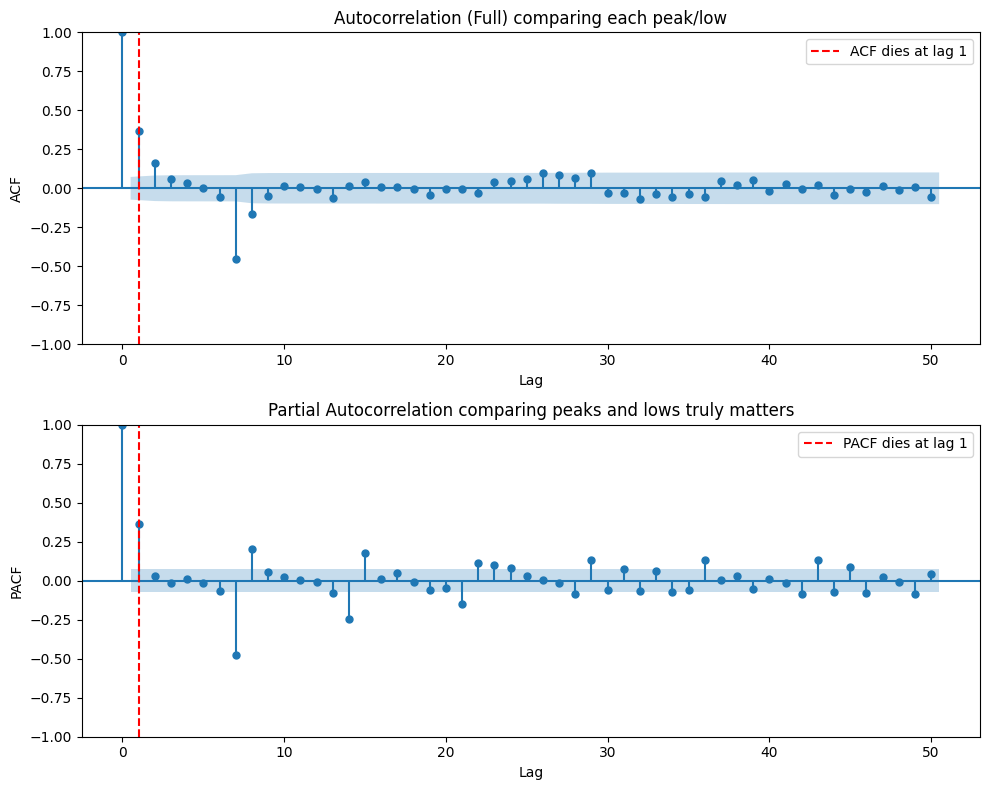

Detected ACF cutoff (q): 1
Detected PACF cutoff (p): 1


In [50]:
acf_cutoff, pacf_cutoff=check_acf_and_pacf('day',data=encoded_d,feature='cnt_by_7b')

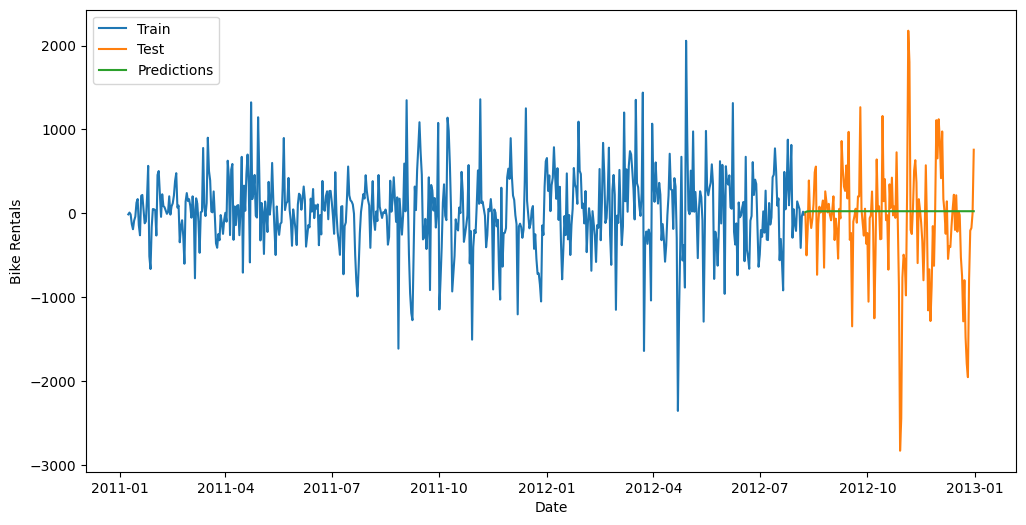

dteday
2012-08-09    14.609476
2012-08-10    21.570442
2012-08-11    24.249728
2012-08-12    25.280989
2012-08-13    25.677923
                ...    
2012-12-27    25.926307
2012-12-28    25.926307
2012-12-29    25.926307
2012-12-30    25.926307
2012-12-31    25.926307
Name: predicted_mean, Length: 145, dtype: float64

In [51]:
arima_model(train_d,test_d,'cnt_by_7b',p=1,d=0,q=1)

In [52]:
acf_vals, confint_acf = acf(encoded_d['cnt_by_7b'], nlags=50, alpha=0.05)
pacf_vals, confint_pacf = pacf(encoded_d['cnt_by_7b'], nlags=50, alpha=0.05, method='ywm')

In [53]:
print(f"acf_values: {acf_vals}")
print(f"pacf_values: {pacf_vals}")

acf_values: [ 1.          0.36491338  0.16178999  0.05704151  0.0337936   0.00231358
 -0.05750861 -0.45262652 -0.16701641 -0.05017712  0.0161982   0.01040396
 -0.00485474 -0.06402302  0.01692333  0.03950309  0.00801547  0.00560738
 -0.00434747 -0.04173686 -0.00475421 -0.00526274 -0.0308635   0.03719784
  0.04371541  0.05652475  0.10090908  0.08529676  0.0660051   0.09517661
 -0.0324706  -0.03330199 -0.06703882 -0.03637745 -0.05392574 -0.03818849
 -0.05389487  0.04801726  0.01917057  0.05058814 -0.01618061  0.02995636
 -0.00527848  0.02194968 -0.04470392 -0.00224367 -0.02150454  0.01252605
 -0.01372122  0.00501089 -0.05843621]
pacf_values: [ 1.          0.36491338  0.03302602 -0.01397358  0.01455156 -0.01615685
 -0.0646093  -0.47645781  0.2047294   0.0548654   0.02383419  0.00227737
 -0.00595743 -0.07530104 -0.24644044  0.17539049  0.01264888  0.04861584
 -0.01065853 -0.05885926 -0.04771576 -0.14751121  0.11592533  0.1013021
  0.07972087  0.03002469  0.00643267 -0.0168927  -0.08460273  

In [54]:
def check_valubal(confint, value):
    significant = []
    for i in range(1, len(value)):
        low, high = confint[i]
        # Outside the confidence band = significant
        if value[i] < low or value[i] > high:
            significant.append(i)
    return significant




In [55]:
significant_p=check_valubal(confint_pacf,pacf_vals)

In [56]:
significant_q=check_valubal(confint_acf,acf_vals)

In [57]:
def find_best_q_and_p(pt, qt, train_d, d=0):
    best_aic = float('inf')
    best_order = None
    for p in pt:
        for q in qt:
            try:
                model = ARIMA(train_d, order=(p,d,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,d,q)
            except Exception as e:
                print(f"Skipped ({p},{d},{q}) -> {e}")
                continue
    print(f'Best order: {best_order}, AIC: {best_aic}')
    return best_order

    

In [58]:
best_order=find_best_q_and_p(significant_p,significant_q,train_d=train_d)

Best order: None, AIC: inf


In [59]:
train_dl,test_dl=divide_train_and_test(encoded_d)

In [60]:
acf_vals, confint_acf = acf(encoded_d['cnt_by_7l'], nlags=50, alpha=0.05)
pacf_vals, confint_pacf = pacf(encoded_d['cnt_by_7l'], nlags=50, alpha=0.05, method='ywm')

In [62]:
significant_p=check_valubal(confint_pacf,pacf_vals)
significant_q=check_valubal(confint_acf,acf_vals)

In [63]:
best_order=find_best_q_and_p(significant_p,significant_q,train_d=train_d,d=0)

Best order: None, AIC: inf


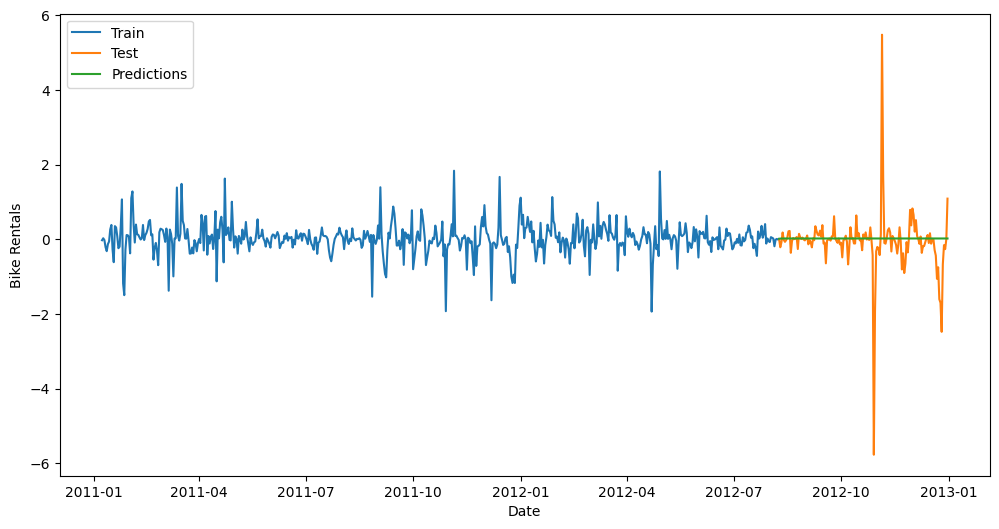

dteday
2012-08-09    0.013211
2012-08-10    0.017568
2012-08-11    0.019165
2012-08-12    0.019750
2012-08-13    0.019965
                ...   
2012-12-27    0.020089
2012-12-28    0.020089
2012-12-29    0.020089
2012-12-30    0.020089
2012-12-31    0.020089
Name: predicted_mean, Length: 145, dtype: float64

In [64]:
arima_model(train_d,test_d,'cnt_by_7l',p=1,d=0,q=1)

In [65]:
best_aic = float('inf')
best_order = None
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(train_d, order=(p,0,q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p,0,q)
        except: pass
print(f'Best order: {best_order}, AIC: {best_aic}')

Best order: None, AIC: inf


Why we used ARIMA initially
for day.csv data set
We first attempted to model the time series using the ARIMA model.
To satisfy the stationarity assumption, we applied differencing with a lag of 7 days (diff(7)), aiming to remove the weekly seasonality component.

What went wrong

Although differencing reduced visible seasonality, the decomposition and ACF/PACF plots still showed a significant seasonal pattern at lag 7.
Additionally, increasing the differencing order (d) caused over-differencing — flattening the series and producing unstable model results (e.g., inf predictions).

In [66]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [67]:
def sarima_parameter_check(p_range, d_range, q_range, P_range, D_range, Q_range, s, y_train):
    best_orders = []
    best_seasonal_orders = []
    best_models = []
    best_aic = float("inf")

    for (p, d, q, P, D, Q) in product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            model = SARIMAX(y_train,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False)

            if res.aic < best_aic:
                best_aic = res.aic
                best_orders.append((p, d, q))
                best_seasonal_orders.append((P, D, Q, s))
                best_models.append(res)

        except Exception as e:
            continue

    return best_orders, best_seasonal_orders, best_models


In [68]:
p_range = range(0, 3)   # try 0, 1, 2
d_range = range(0, 2)   # usually 0 or 1
q_range = range(0, 3)   # try 0, 1, 2

P_range = range(0, 2)   # seasonal AR 0 or 1
D_range = range(0, 2)   # seasonal differencing 0 or 1
Q_range = range(0, 2)   # seasonal MA 0 or 1
s = 7                   # 7-day seasonality

In [83]:
best_orders,best_seasonal_orders,best_models=sarima_parameter_check(p_range, d_range, q_range, P_range, D_range, Q_range,7,train_d['cnt'])

/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: Val

In [69]:
def checking_best_models(train,test,best_models):
    model_summary=[]
    for model_fit in best_models:
        pred = model_fit.forecast(steps=len(test))
        plt.figure(figsize=(12,6))
        plt.plot(train.index, train['cnt'], label='Train')
        plt.plot(test.index, test['cnt'], label='Test')
        plt.plot(test.index, pred, label='SARIMA Predictions', color='green')
        plt.legend()
        plt.show()

        print(model_fit.summary())
        model_summary.append(model_fit.summary())
    return model_summary

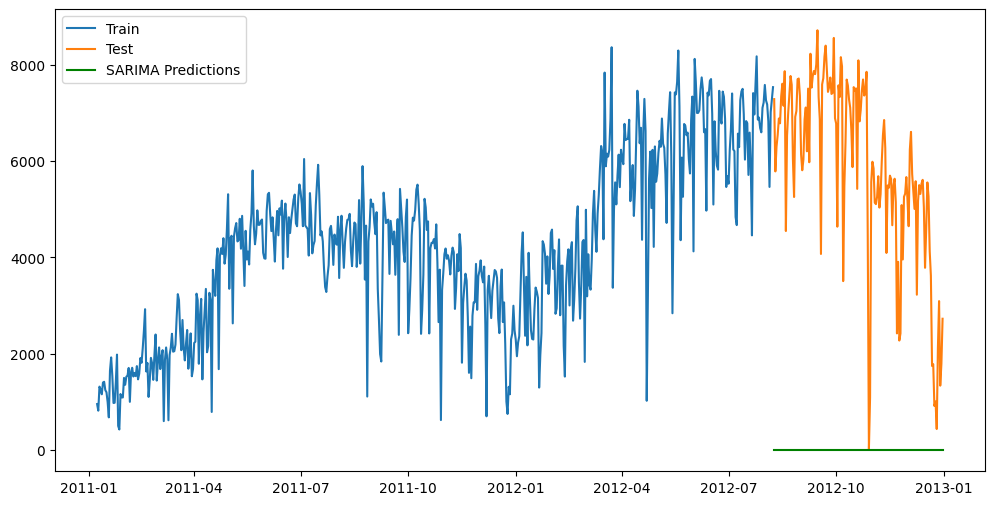

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  579
Model:                        SARIMAX   Log Likelihood               -5690.270
Date:                Sun, 26 Oct 2025   AIC                          11382.540
Time:                        11:39:32   BIC                          11386.899
Sample:                    01-08-2011   HQIC                         11384.240
                         - 08-08-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.079e+07   2.31e+06      8.992      0.000    1.63e+07    2.53e+07
Ljung-Box (L1) (Q):                 403.19   Jarque-Bera (JB):                10.81
Prob(Q):                              0.00   Pr

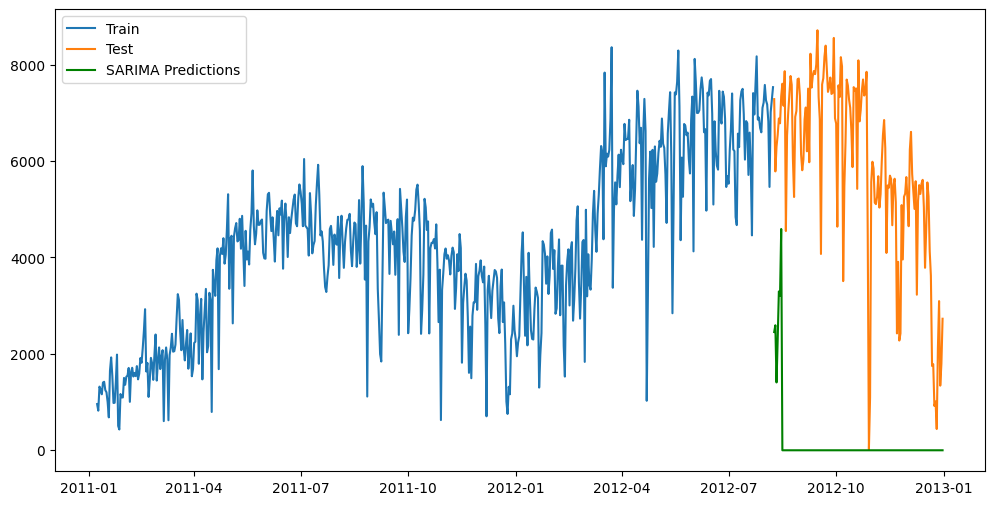

                                 SARIMAX Results                                 
Dep. Variable:                       cnt   No. Observations:                  579
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood               -5455.596
Date:                   Sun, 26 Oct 2025   AIC                          10915.192
Time:                           11:39:32   BIC                          10923.886
Sample:                       01-08-2011   HQIC                         10918.584
                            - 08-08-2012                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7        0.7873      0.066     11.903      0.000       0.658       0.917
sigma2      2.153e+07   5.31e-10   4.05e+16      0.000    2.15e+07    2.15e+07
Ljung-Box (L1) (Q):         

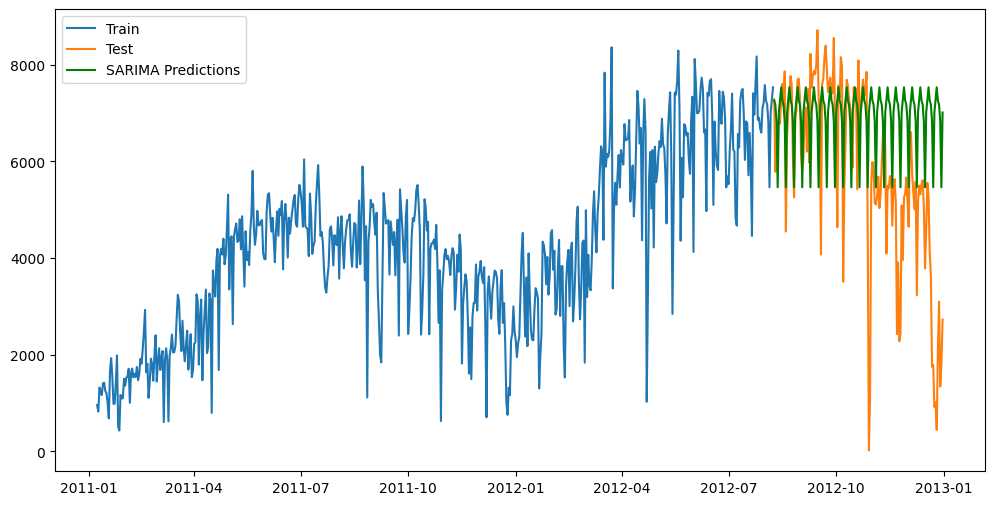

                                SARIMAX Results                                
Dep. Variable:                     cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood               -4866.999
Date:                 Sun, 26 Oct 2025   AIC                           9735.997
Time:                         11:39:32   BIC                           9740.345
Sample:                     01-08-2011   HQIC                          9737.693
                          - 08-08-2012                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.465e+06   5.74e+04     25.499      0.000    1.35e+06    1.58e+06
Ljung-Box (L1) (Q):                  38.52   Jarque-Bera (JB):               154.22
Prob(Q):                              0

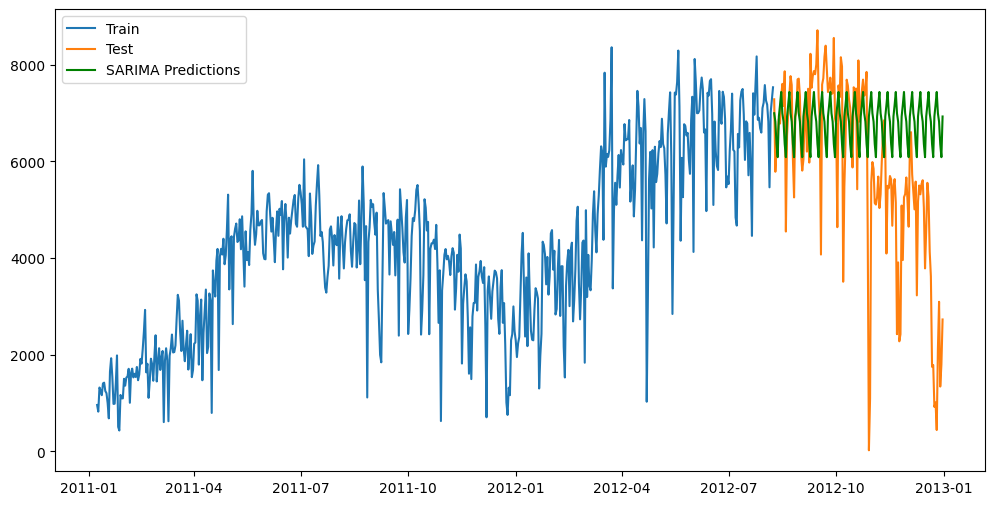

                                 SARIMAX Results                                 
Dep. Variable:                       cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood               -4709.677
Date:                   Sun, 26 Oct 2025   AIC                           9423.354
Time:                           11:39:32   BIC                           9432.024
Sample:                       01-08-2011   HQIC                          9426.739
                            - 08-08-2012                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.5935      0.031    -18.843      0.000      -0.655      -0.532
sigma2      1.049e+06   4.49e+04     23.386      0.000    9.61e+05    1.14e+06
Ljung-Box (L1) (Q):         

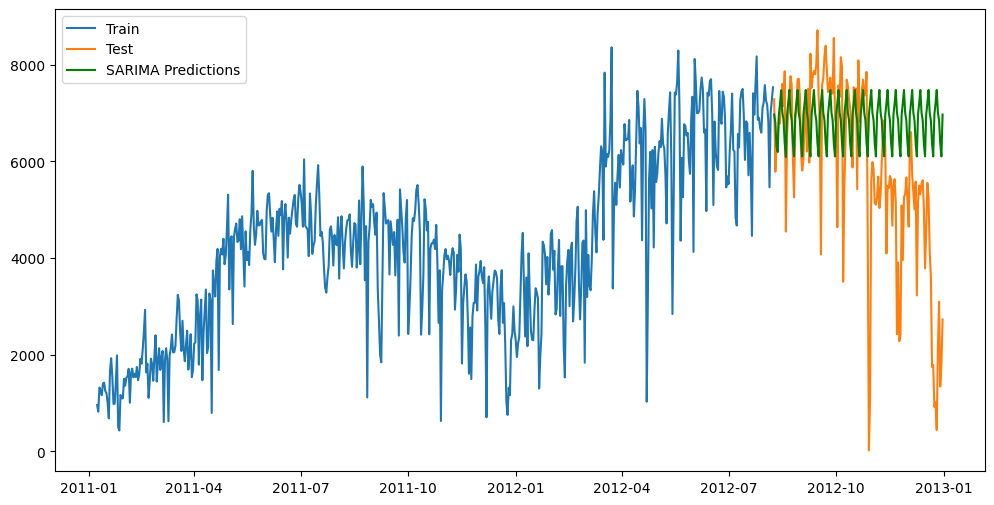

                                 SARIMAX Results                                 
Dep. Variable:                       cnt   No. Observations:                  579
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -4706.959
Date:                   Sun, 26 Oct 2025   AIC                           9419.917
Time:                           11:39:33   BIC                           9432.922
Sample:                       01-08-2011   HQIC                          9424.994
                            - 08-08-2012                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1435      0.059     -2.435      0.015      -0.259      -0.028
ma.S.L7       -0.5158      0.056     -9.136      0.000      -0.626      -0.405
sigma2      1.042e+06   4.41

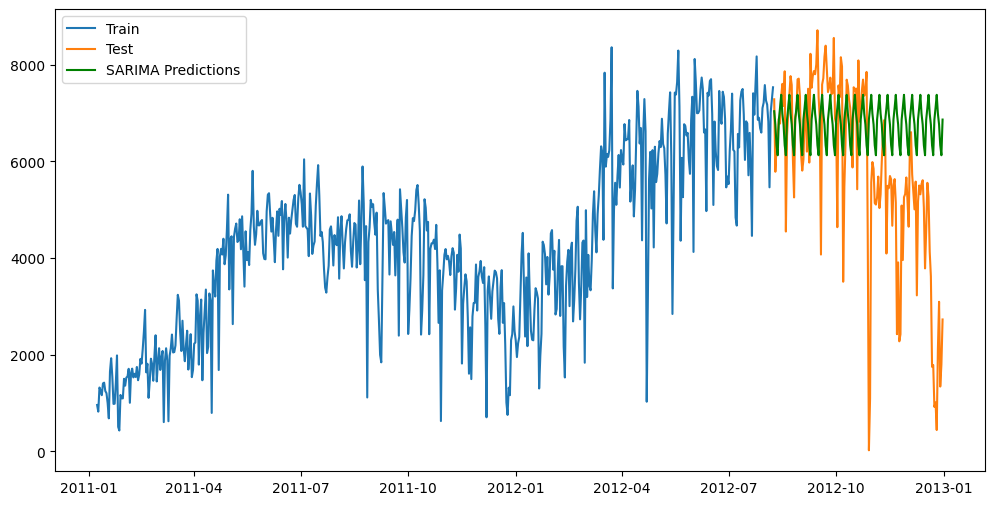

                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  579
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -4665.152
Date:                           Sun, 26 Oct 2025   AIC                           9336.305
Time:                                   11:39:33   BIC                           9349.305
Sample:                               01-08-2011   HQIC                          9341.380
                                    - 08-08-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3339      0.036      9.299      0.000       0.263       0.404
ma.S.L7       -0.6627      0.030    -22.130

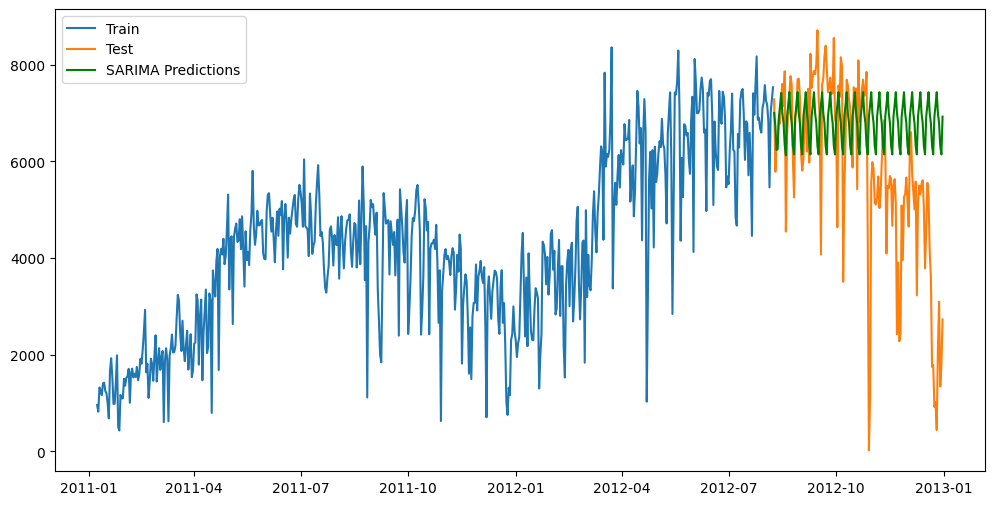

                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  579
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -4661.138
Date:                           Sun, 26 Oct 2025   AIC                           9330.276
Time:                                   11:39:33   BIC                           9347.609
Sample:                               01-08-2011   HQIC                          9337.042
                                    - 08-08-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3409      0.037      9.259      0.000       0.269       0.413
ar.S.L7       -0.1623      0.050     -3.262

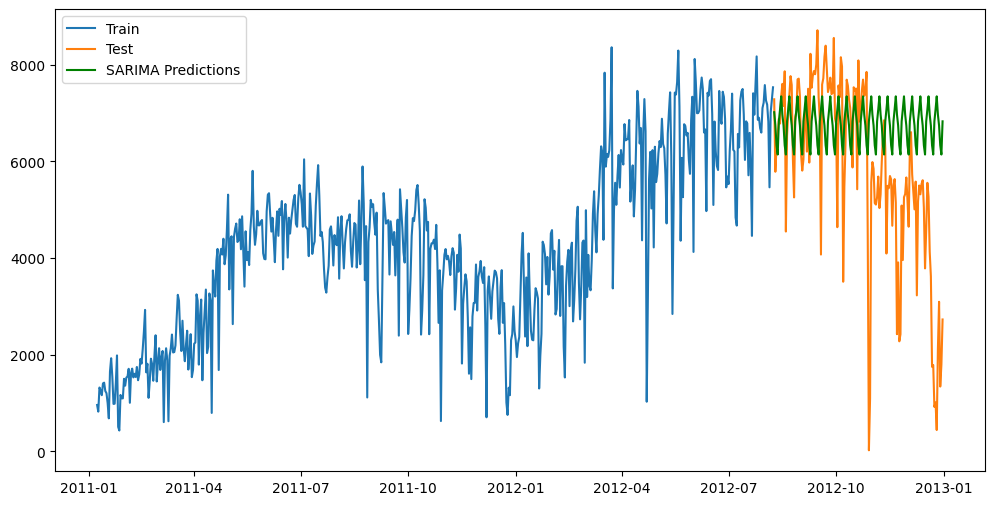

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                  579
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -4648.936
Date:                             Sun, 26 Oct 2025   AIC                           9305.872
Time:                                     11:39:33   BIC                           9323.198
Sample:                                 01-08-2011   HQIC                          9312.637
                                      - 08-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3667      0.036     10.169      0.000       0.296       0.437
ma.L2          0.1623      

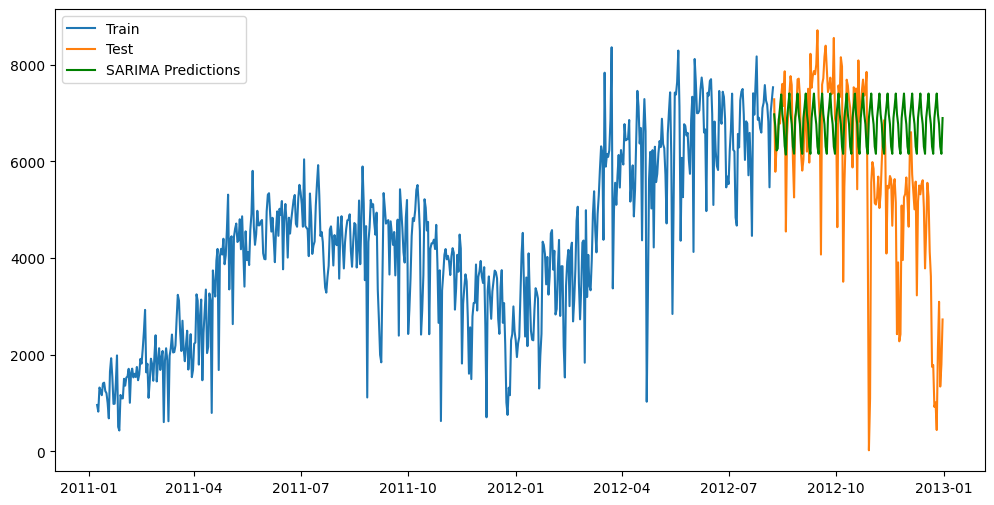

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                  579
Model:             SARIMAX(0, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -4645.132
Date:                             Sun, 26 Oct 2025   AIC                           9300.264
Time:                                     11:39:33   BIC                           9321.922
Sample:                                 01-08-2011   HQIC                          9308.720
                                      - 08-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3759      0.038     10.025      0.000       0.302       0.449
ma.L2          0.1589      

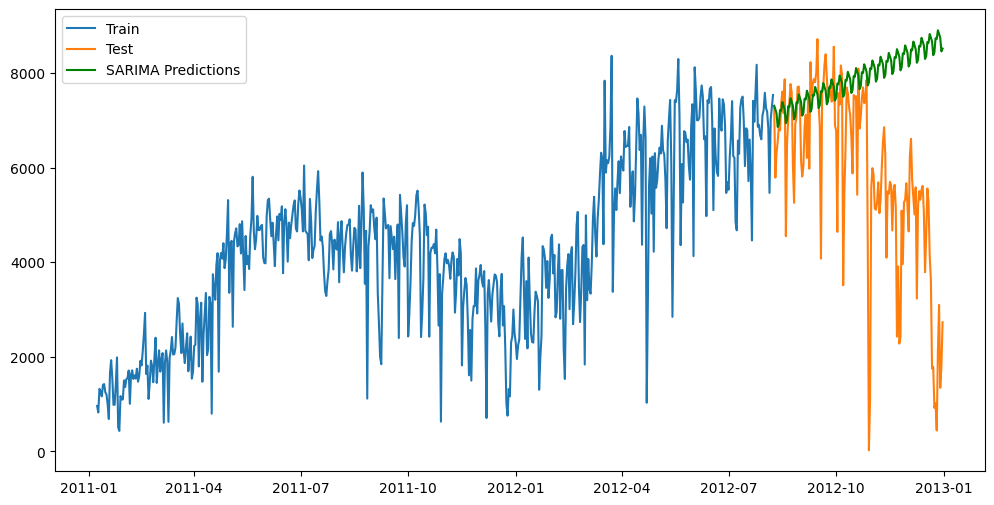

                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4617.429
Date:                           Sun, 26 Oct 2025   AIC                           9240.858
Time:                                   11:39:34   BIC                           9253.853
Sample:                               01-08-2011   HQIC                          9245.931
                                    - 08-08-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8147      0.020    -40.040      0.000      -0.855      -0.775
ma.S.L7       -1.0349      0.017    -60.401

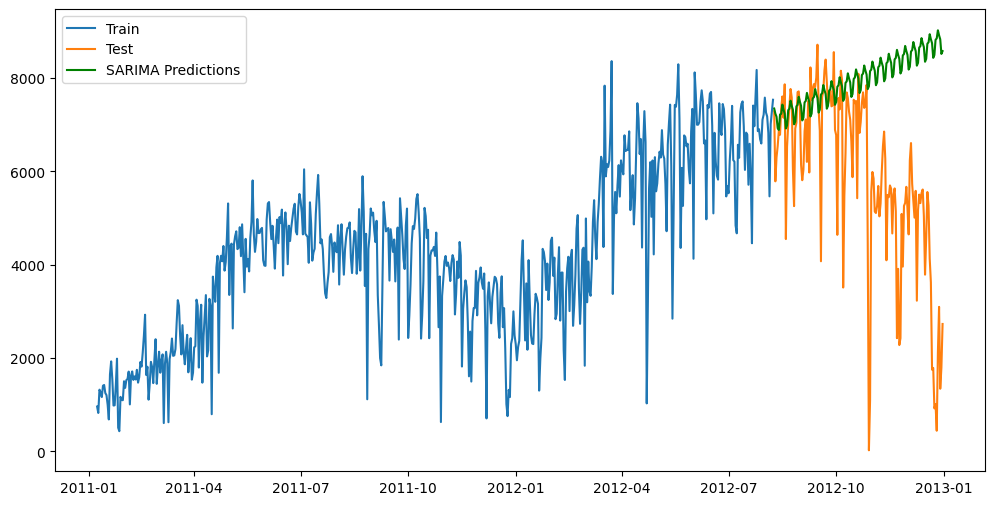

                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4616.329
Date:                           Sun, 26 Oct 2025   AIC                           9240.658
Time:                                   11:39:34   BIC                           9257.984
Sample:                               01-08-2011   HQIC                          9247.422
                                    - 08-08-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8093      0.021    -38.587      0.000      -0.850      -0.768
ar.S.L7       -0.0667      0.038     -1.759

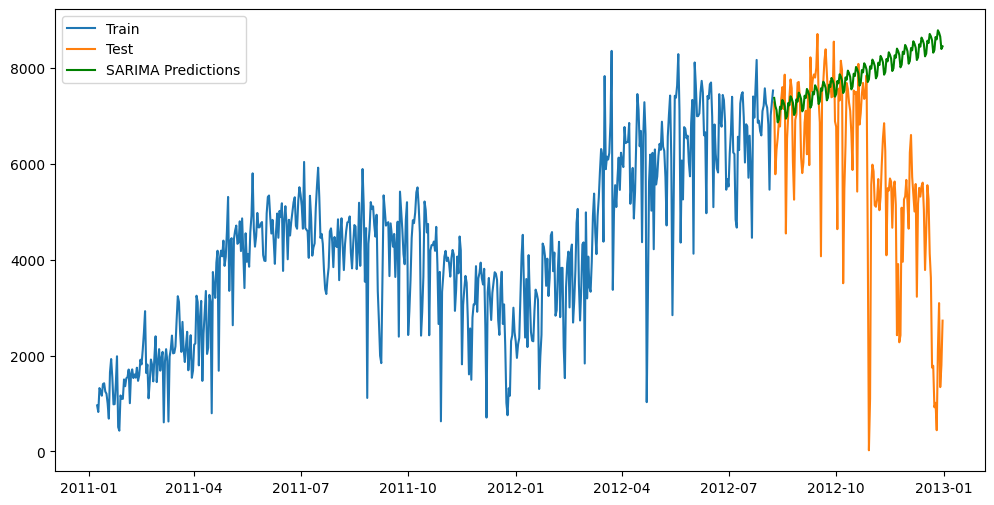

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -4593.004
Date:                             Sun, 26 Oct 2025   AIC                           9194.008
Time:                                     11:39:34   BIC                           9211.327
Sample:                                 01-08-2011   HQIC                          9200.770
                                      - 08-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6204      0.036    -17.007      0.000      -0.692      -0.549
ma.L2         -0.2301      

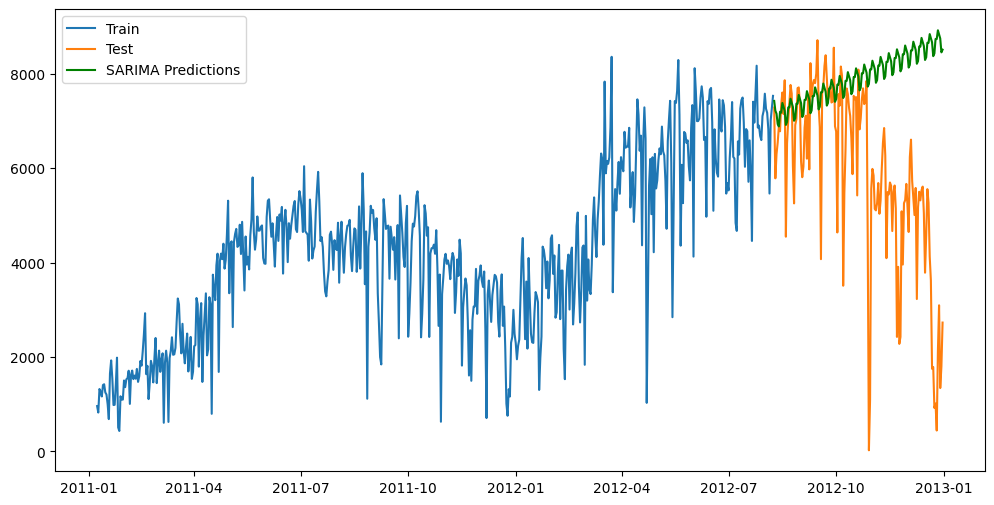

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                  579
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -4591.745
Date:                             Sun, 26 Oct 2025   AIC                           9193.490
Time:                                     11:39:34   BIC                           9215.139
Sample:                                 01-08-2011   HQIC                          9201.943
                                      - 08-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8770      0.057    -15.379      0.000      -0.989      -0.765
ma.L2         -0.3025      

In [104]:
model_summary=checking_best_models(train_d,test_d,best_models)

In [70]:
acf_vals, confint_acf = acf(encoded_d['cnt_by_7b'], nlags=50, alpha=0.05)
pacf_vals, confint_pacf = pacf(encoded_d['cnt_by_7b'], nlags=50, alpha=0.05, method='ywm')

In [71]:
best_q=check_valubal(confint_acf,acf_vals)
best_p=check_valubal(confint_pacf,pacf_vals)

<Figure size 640x480 with 0 Axes>

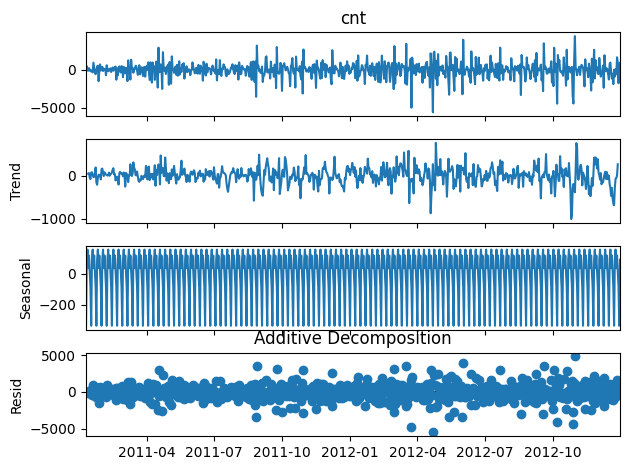

In [72]:
plt.clf()  # Clear any existing figures

additive_result = seasonal_decompose(encoded_d['cnt'].diff().dropna(), model='additive', period=7)
additive_result.plot()
plt.title('Additive Decomposition')
plt.show()

In [73]:
for model in model_summary:
    print(model)

NameError: name 'model_summary' is not defined

Several SARIMA models were tested using a grid search over different (p,d,q)(P,D,Q,s) combinations.
Based on the Akaike Information Criterion (AIC), the best-performing model was SARIMA(0,1,2)×(1,1,1,7) with an AIC of 9193.49.
This configuration captures both the non-seasonal and weekly seasonal components effectively.
The residual diagnostics showed no significant autocorrelation (Ljung-Box p > 0.05), indicating that the model adequately explains the time series structure.
Although residuals deviate slightly from normality, the model remains suitable for forecasting purposes.

In [74]:
#RNNs
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

2025-10-26 15:37:26.249301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30


2025-10-26 15:37:31.070403: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0854
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0153
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138
Epoch 16/30
18/1

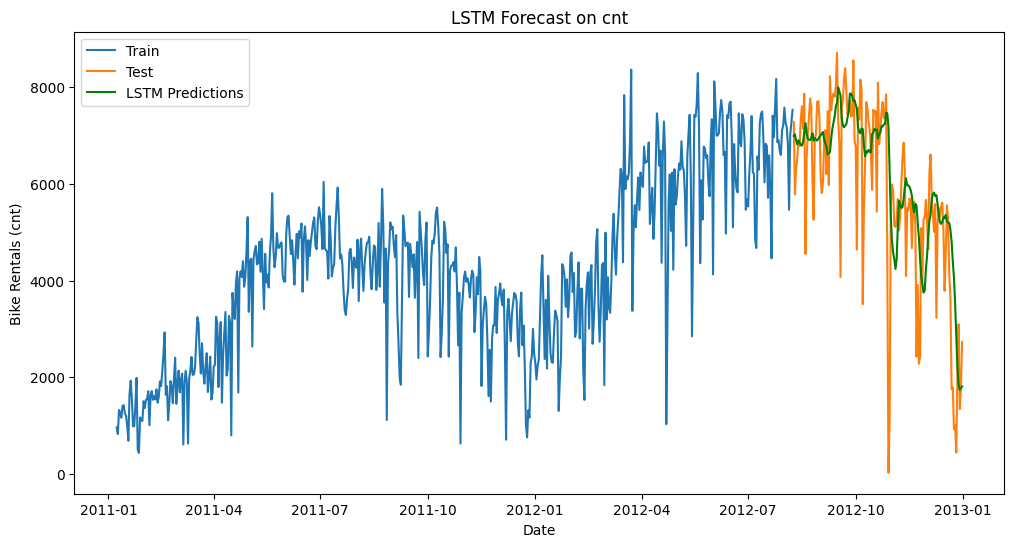

In [75]:


# --- Scaling the training data ---
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_d[['cnt']])

# --- Prepare training data (past 7 days → next day) ---
X_train, y_train = [], []
for i in range(7, len(train_scaled)):
    X_train.append(train_scaled[i-7:i, 0])  # 14 previous values
    y_train.append(train_scaled[i, 0])      # next value

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# --- Build LSTM model ---
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# --- Train model ---
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# --- Prepare test data ---
inputs = encoded_d[len(encoded_d) - len(test_d) - 7:]['cnt'].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# --- Predictions ---
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(train_d.index, train_d['cnt'], label='Train')
plt.plot(test_d.index, test_d['cnt'], label='Test')
plt.plot(test_d.index, predictions, label='LSTM Predictions', color='green')
plt.xlabel("Date")
plt.ylabel("Bike Rentals (cnt)")
plt.title("LSTM Forecast on cnt")
plt.legend()
plt.show()


In [76]:
from tensorflow.keras.layers import GRU

def rungru(train,test,data,feature,d):
    # --- Scaling the training data ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train[[feature]])

    # --- Prepare training data (past 7 days → next day) ---
    X_train, y_train = [], []
    for i in range(d, len(train_scaled)):
        X_train.append(train_scaled[i-d:i, 0])  # 14 previous values
        y_train.append(train_scaled[i, 0])      # next value

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # --- Build LSTM model ---
    model = Sequential()
    model.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(GRU(100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # --- Train model ---
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

    # --- Prepare test data ---
    inputs = data[len(data) - len(test) - d:][feature].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(d, len(inputs)):
        X_test.append(inputs[i-d:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # --- Predictions ---
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # --- Plot results ---
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['cnt'], label='Train')
    plt.plot(test.index, test['cnt'], label='Test')
    plt.plot(test.index, predictions, label='LSTM Predictions', color='green')
    plt.xlabel("Date")
    plt.ylabel("Bike Rentals (cnt)")
    plt.title("LSTM Forecast on cnt")
    plt.legend()
    plt.show()


/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0775
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0134
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0129
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0133
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131
Epoch

/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


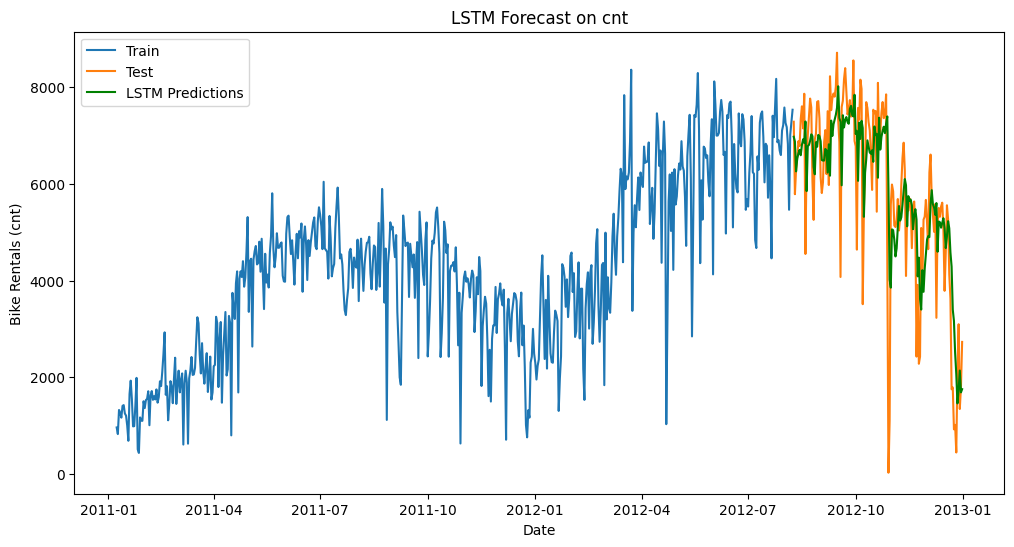

In [149]:
rungru(train_d,test_d,encoded_d,'cnt',d=7)

ARIMA and SARIMA failed to produce accurate forecasts because the dataset exhibited non-linear and irregular seasonal patterns. Differencing to achieve stationarity eliminated meaningful correlations, leading to poor predictions. In contrast, the LSTM-based RNN model captured both short-term and long-term dependencies directly from raw sequential data, adapting to complex non-linear patterns and yielding more realistic forecasts.

Next we going to check 'cnt' time series in hour data set

In [114]:
I_h=adf_test(encoded_h,'cnt')

ADF Statistic: -6.82291871189509
p-value: 1.9808626277978587e-09
Series is stationary
Critical Value (1%): -3.430727265144117
At 1% level, series is stationary
Critical Value (5%): -2.8617067365231246
At 5% level, series is stationary
Critical Value (10%): -2.5668587495404225
At 10% level, series is stationary


<Figure size 640x480 with 0 Axes>

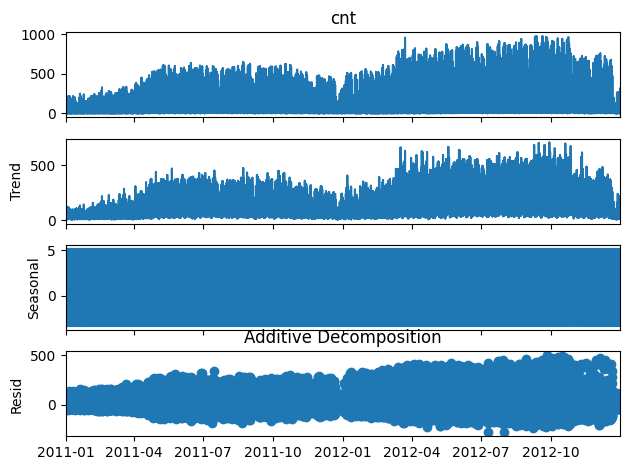

In [77]:
plt.clf()  # Clear any existing figures

additive_result = seasonal_decompose(encoded_h['cnt'], model='additive',period=7)
additive_result.plot()
plt.title('Additive Decomposition')
plt.show()

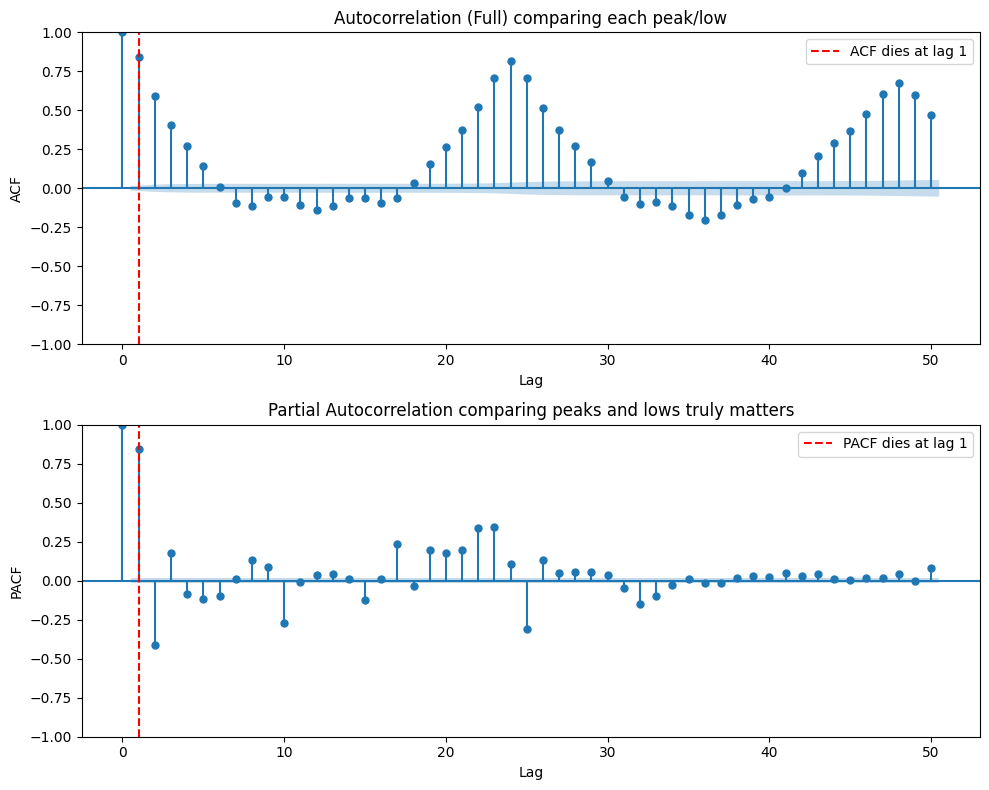

Detected ACF cutoff (q): 1
Detected PACF cutoff (p): 1


In [78]:
p,q=check_acf_and_pacf('hour',encoded_h,'cnt')

In [124]:
train_h,test_h=divide_train_and_test(encoded_h)

In [126]:
acf_vals, confint_acf = acf(encoded_h['cnt'], nlags=50, alpha=0.05)
pacf_vals, confint_pacf = pacf(encoded_h['cnt'], nlags=50, alpha=0.05, method='ywm')

In [127]:
acf_lst=check_valubal(confint_acf,acf_vals)
pacf_lst=check_valubal(confint_pacf,pacf_vals)

In [128]:
best=find_best_q_and_p(pacf_lst,acf_lst,train_d=train_h,d=0)

Best order: None, AIC: inf


/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

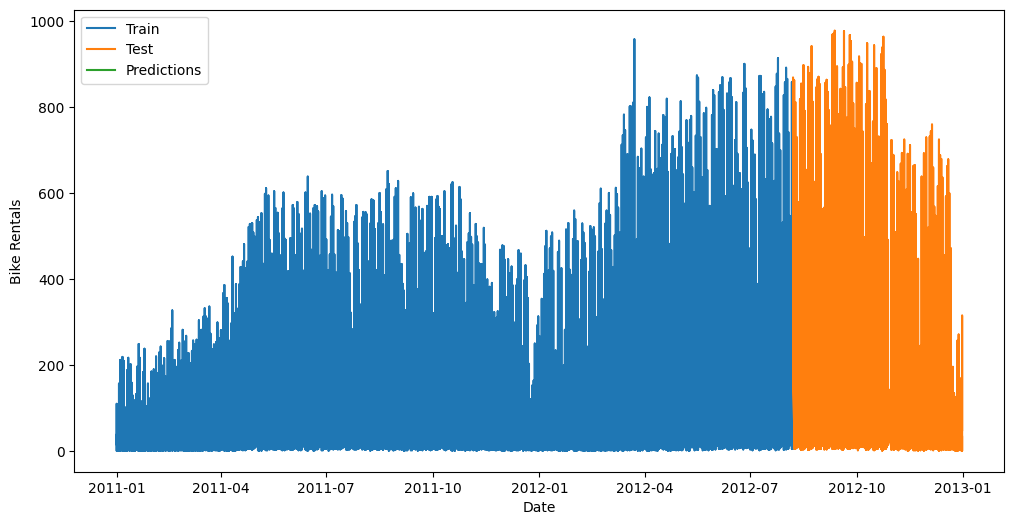

dteday
2012-08-07   NaN
2012-08-07   NaN
2012-08-07   NaN
2012-08-07   NaN
2012-08-07   NaN
              ..
2012-12-31   NaN
2012-12-31   NaN
2012-12-31   NaN
2012-12-31   NaN
2012-12-31   NaN
Name: predicted_mean, Length: 3476, dtype: float64

In [129]:
arima_model(train_h,test_h,'cnt',1,0,1)

In [130]:
p_range = range(0, 3)   # try 0, 1, 2
d_range = range(0, 2)   # usually 0 or 1
q_range = range(0, 3)   # try 0, 1, 2

P_range = range(0, 2)   # seasonal AR 0 or 1
D_range = range(0, 2)   # seasonal differencing 0 or 1
Q_range = range(0, 2)   # seasonal MA 0 or 1
s = 7    

In [133]:
best_orders,best_seasonal_orders,best_models=sarima_parameter_check(pacf_lst, d_range, acf_lst, P_range, D_range, Q_range,7,train_d['cnt'])

In [134]:
model_summary=checking_best_models(train_h,test_h,best_models)

In [79]:


def runltms(train,test,data,feature,d):
    # --- Scaling the training data ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train[[feature]])

    # --- Prepare training data (past 7 days → next day) ---
    X_train, y_train = [], []
    for i in range(d, len(train_scaled)):
        X_train.append(train_scaled[i-d:i, 0])  # 14 previous values
        y_train.append(train_scaled[i, 0])      # next value

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # --- Build LSTM model ---
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # --- Train model ---
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

    # --- Prepare test data ---
    inputs = data[len(data) - len(test) - d:][feature].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(d, len(inputs)):
        X_test.append(inputs[i-d:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # --- Predictions ---
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # --- Plot results ---
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['cnt'], label='Train')
    plt.plot(test.index, test['cnt'], label='Test')
    plt.plot(test.index, predictions, label='LSTM Predictions', color='green')
    plt.xlabel("Date")
    plt.ylabel("Bike Rentals (cnt)")
    plt.title("LSTM Forecast on cnt")
    plt.legend()
    plt.show()


Epoch 1/30


/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0119
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0058
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0046
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0044
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0042
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0041
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0040
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0039
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0038
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0036
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0035
Epoch 12/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0033
Epoch 13/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0032
Epoch 14/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0031
Epoch 15/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step 

/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


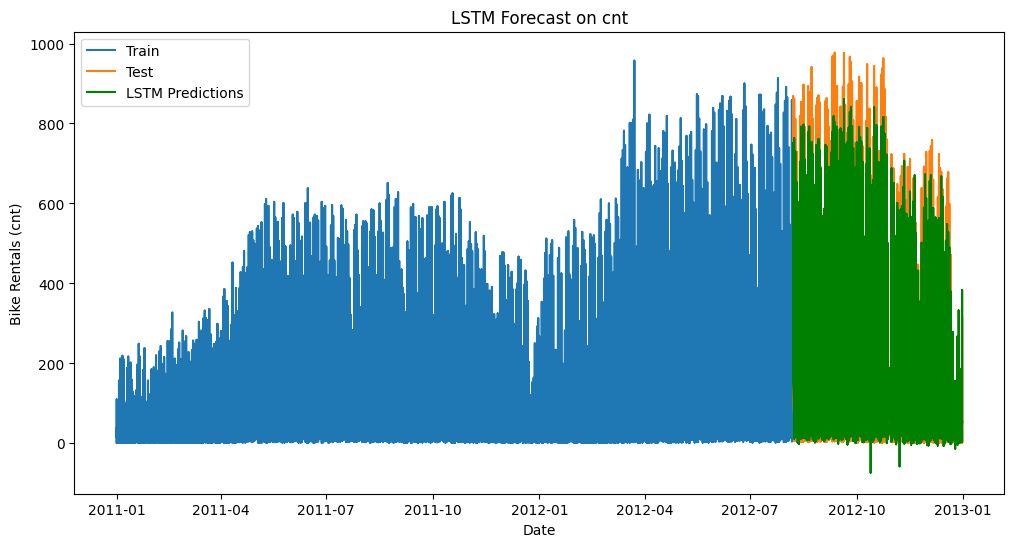

In [144]:
runltms(train_h,test_h,encoded_h,'cnt',d=7)

Epoch 1/30


/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0091
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0052
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0044
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0042
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0039
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0037
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0035
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0035
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0034
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0033
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0032
Epoch 12/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0031
Epoch 13/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0030
Epoch 14/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0029
Epoch 15/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step 

/home/jack/data_mining/dminevenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


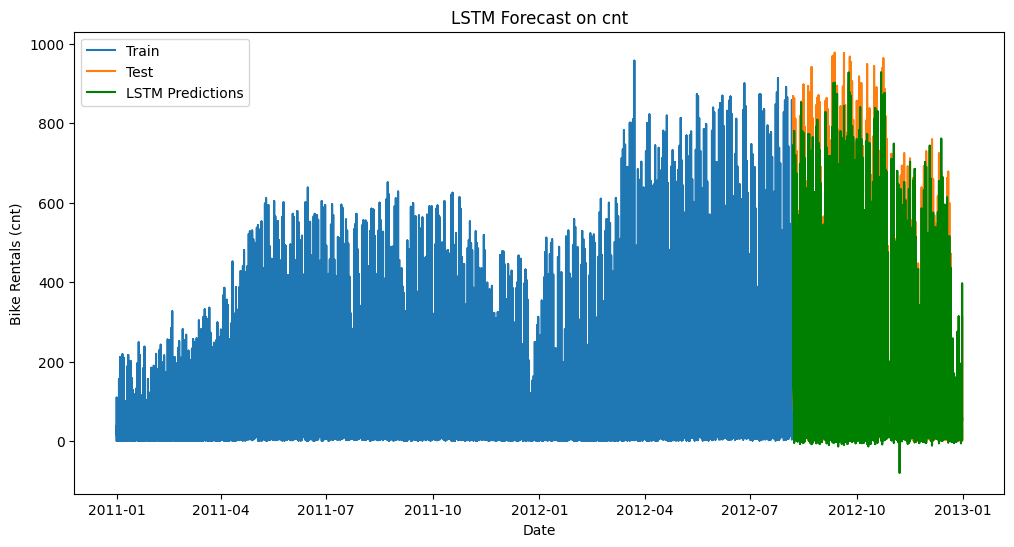

In [150]:
rungru(train_h,test_h,encoded_h,'cnt',d=7)

In [1]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# --- Define ranges for p,d,q and seasonal P,D,Q ---
p = d = q = range(0, 3)           # ARIMA part
P = D = Q = range(0, 2)           # seasonal part
s = 7                              # weekly seasonality

pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# exogenous variable
exog_train = train_h[['temp']]
exog_test = test_h[['temp']]

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train_h['cnt'],
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            exog=exog_train,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except:
            continue

print(f"Best SARIMAX order: {best_order}, seasonal_order: {best_seasonal_order}, AIC: {best_aic}")

# --- Forecast using the best model ---
forecast = best_model.get_forecast(steps=len(test_h), exog=exog_test)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(train_h.index, train_h['cnt'], label='Train')
plt.plot(test_h.index, test_h['cnt'], label='Test')
plt.plot(test_h.index, preds, label='SARIMAX Forecast', color='green')
plt.fill_between(test_h.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.2)
plt.legend()
plt.show()


NameError: name 'train_h' is not defined

In [80]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [81]:
def dtw_clustering(data, feature, n_clusters=3, max_iter=10, plot=True):
    """
    Perform DTW-based clustering on a time series feature.

    Parameters:
    - data: pd.DataFrame with your time series data (long format with one series per row or single series).
    - feature: str, column name to cluster.
    - n_clusters: int, number of clusters.
    - max_iter: int, max iterations for clustering.
    - plot: bool, whether to plot clusters.

    Returns:
    - labels: cluster labels for each time series.
    """
    # Convert the feature column(s) to a tslearn time series dataset
    if len(data.shape) == 1 or data.shape[1] == 1:
        # Single series case
        series_list = [data[feature].values]
    else:
        # Multiple series, each row is a series
        series_list = [row for row in data[feature].values]

    X = to_time_series_dataset(series_list)

    # Fit DTW KMeans
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=max_iter, random_state=42)
    labels = model.fit_predict(X)

    # Plot clusters if requested
    if plot:
        plt.figure(figsize=(12, 6))
        for cluster in range(n_clusters):
            for i, series in enumerate(X[labels == cluster]):
                plt.plot(series.ravel(), alpha=0.5)
        plt.title(f"DTW Clustering ({feature}) with {n_clusters} clusters")
        plt.show()

    return labels

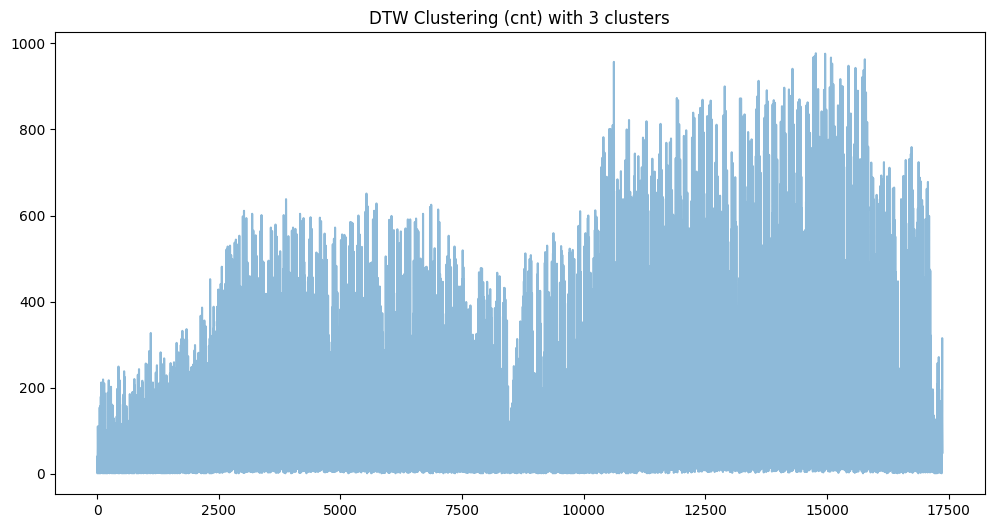

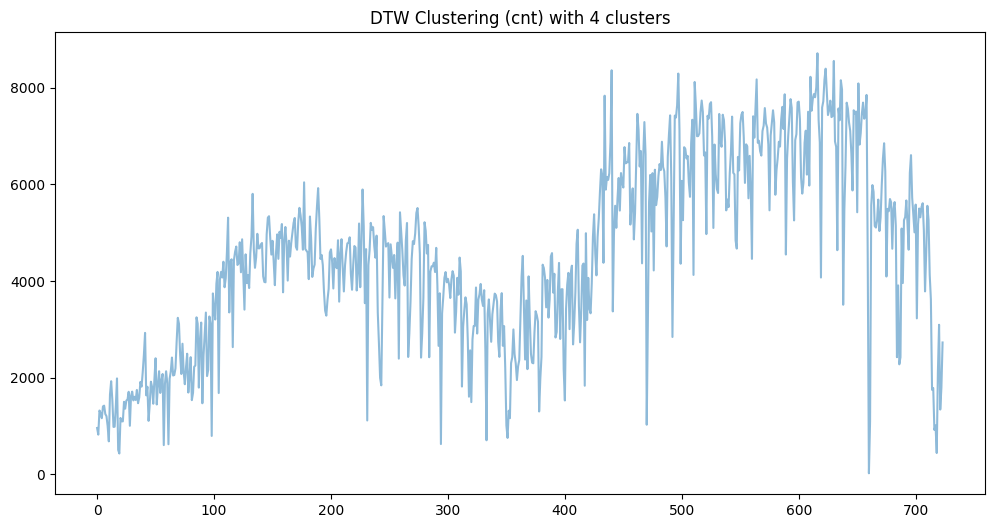

In [82]:
# Single series example
labels = dtw_clustering(encoded_h, feature='cnt', n_clusters=3)

# If you have multiple series, for example encoded_d with many features
labels = dtw_clustering(encoded_d, feature='cnt', n_clusters=4)
